# QMD reproducing Hahn-echo dynamics

### uses offline data

In [1]:
%matplotlib inline
import qinfer as qi
import qutip as qt
import numpy as np
import scipy as sp
import math as mth
from IPython.display import display, Math, Latex
from functools import partial
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
import datetime
import os as os
import time as time

In [3]:
import importlib as imp

In [4]:
import logging as logging
import warnings as warnings
import sys

%run LoggingCode.py

Importing Local Function for Hamiltonian learning

In [5]:
# Add personalized library to PYTHONPATH
sys.path.append(os.path.join(".."))
sys.path.append(os.path.join("..","Libraries","QML_lib"))

In [6]:
from Norms import *
from IOfuncts import *
from EvalLoss import *

import Distrib as dist
import ProbeStates as pros
import multiPGH as mpgh
import HahnSimQMD as gsi
import Evo as evo
import IOfuncts as mIO

In [7]:
""" filter only the Weight Clipping warning """
#SET LEVEL WARNINGS TO 0 In FINAL VERSION
warnings.filterwarnings("ignore", message='Negative weights occured', category=RuntimeWarning)

# Model learning functions


In [467]:
import Utils as uti
import Models as mods
import BayesF as bayf

import ModLearn as mdl
import QMD_Hahn as qmd
import QML_Hahn as qml
import QMD_Utils as quti
import Moves as mov

import SETTINGS as SETTINGS
SETTINGS.init()

import HahnTheoModels as HTM

..\SETTINGS.py:18: UserWarning: Remember to set the correct tau_c, T2 and offset in the SETTINGS.PY
  warnings.warn("Remember to set the correct tau_c, T2 and offset in the SETTINGS.PY")


## Reload when needed

In [468]:
imp.reload(pros)
imp.reload(dist)
imp.reload(mpgh)
imp.reload(gsi)
imp.reload(evo)
imp.reload(mdl)
imp.reload(uti)
imp.reload(mods)
imp.reload(bayf)
imp.reload(qmd)
imp.reload(quti)
imp.reload(qml)
imp.reload(mIO)
imp.reload(SETTINGS)
imp.reload(HTM)
imp.reload(mov)

<module 'Moves' from '..\\Libraries\\QML_lib\\Moves.py'>

### Data Export

In [10]:
# tell the user where files will be saved
dire = os.getcwd()+"/test_results/"
dire = os.path.normpath(dire)
print('Files will be saved in:')
print(dire)

Files will be saved in:
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results


### Plot Data

In [11]:
SETTINGS.init()

..\SETTINGS.py:18: UserWarning: Remember to set the correct tau_c, T2 and offset in the SETTINGS.PY
  warnings.warn("Remember to set the correct tau_c, T2 and offset in the SETTINGS.PY")


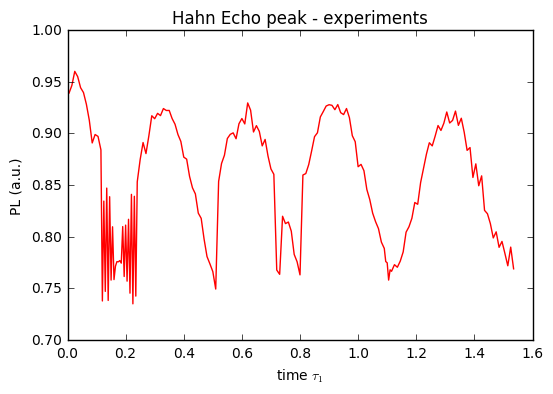

In [12]:
plt.plot(SETTINGS.mydata[:,0], SETTINGS.mydata[:,1], "r-")

plt.xlim([0,1.6])

plt.title('Hahn Echo peak - experiments')
plt.xlabel(r'time $\tau_1$')
plt.ylabel('PL (a.u.)')

plt.show()

# MODEL LEARNING TEST: Offline Data

### Preliminaries

In [535]:
imp.reload(mov)

<module 'Moves' from '..\\Libraries\\QML_lib\\Moves.py'>

In [536]:
GlobalDB = mov.InitialiseDB(RootN_Qbit = [0])
GlobalDB

,<Name>,All_Operators,LogL_Ext,N_Qbit,N_params,Origin_epoch,QML_Class,Selected,Status
0,sx0,"[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], ...",None,[0],1,0,None,False,Ready
1,sy0,"[[[0j, 0j, -1j, -0j], [0j, 0j, -0j, -1j], [1j,...",None,[0],1,0,None,False,Ready
2,sz0,"[[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], ...",None,[0],1,0,None,False,Ready


In [537]:
GlobalDB = mov.AddDBnewNparam_SameQ(GlobalDB, epoch = 0, RootN_Qbit = [0], MaxParamRate =3)
GlobalDB

Max Param being analysed for highest qubit operations: 1


,<Name>,All_Operators,LogL_Ext,N_Qbit,N_params,Origin_epoch,QML_Class,Selected,Status
0,sx0,"[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], ...",None,[0],1,0,None,False,Ready
1,sy0,"[[[0j, 0j, -1j, -0j], [0j, 0j, -0j, -1j], [1j,...",None,[0],1,0,None,False,Ready
2,sz0,"[[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], ...",None,[0],1,0,None,False,Ready
3,sx0sy0,"[[[0j, 0j, (1+0j), 0j], [0j, 0j, 0j, (1+0j)], ...",None,[0],2,0,None,False,Ready
4,sx0sz0,"[[[0j, 0j, (1+0j), 0j], [0j, 0j, 0j, (1+0j)], ...",None,[0],2,0,None,False,Ready
5,sy0sz0,"[[[0j, 0j, -1j, -0j], [0j, 0j, -0j, -1j], [1j,...",None,[0],2,0,None,False,Ready


In [538]:
# REMEMBER TO CALL THE QML Class as follows when initialising, to keep correct number of brackets
np.array(GlobalDB[ "All_Operators"][0])

array([[[ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.]]])

In [539]:
GlobalDB = mov.AddHFinteraction_NewQ(GlobalDB, epoch = 0, dim=2, inter_qbits = [0,1])
GlobalDB

,<Name>,All_Operators,LogL_Ext,N_Qbit,N_params,Origin_epoch,QML_Class,Selected,Status
0,sx0,"[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], ...",None,[0],1,0,None,False,Ready
1,sy0,"[[[0j, 0j, -1j, -0j], [0j, 0j, -0j, -1j], [1j,...",None,[0],1,0,None,False,Ready
2,sz0,"[[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], ...",None,[0],1,0,None,False,Ready
3,sx0sy0,"[[[0j, 0j, (1+0j), 0j], [0j, 0j, 0j, (1+0j)], ...",None,[0],2,0,None,False,Ready
4,sx0sz0,"[[[0j, 0j, (1+0j), 0j], [0j, 0j, 0j, (1+0j)], ...",None,[0],2,0,None,False,Ready
5,sy0sz0,"[[[0j, 0j, -1j, -0j], [0j, 0j, -0j, -1j], [1j,...",None,[0],2,0,None,False,Ready
6,HFx01,"[[[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1...",None,"[0, 1]",1,0,None,False,Ready
7,HFy01,"[[[0j, -0j, -0j, (-1+0j)], [0j, 0j, (1-0j), -0...",None,"[0, 1]",1,0,None,False,Ready
8,HFz01,"[[[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], ...",None,"[0, 1]",1,0,None,False,Ready


In [546]:
GlobalDB = mov.AddScalarComboOp_NewQ(GlobalDB, epoch = 0, dim=2, inter_qbits = [0,1])
GlobalDB

Max Param being analysed for operators combinations: 6
['HFx01', 'HFy01', 'HFz01', 'sx1', 'sy1', 'sz1']


..\Libraries\QML_lib\Moves.py:235: UserWarning: The tree exploration has reached the highest N_params for 1 qubit
  


,<Name>,All_Operators,LogL_Ext,N_Qbit,N_params,Origin_epoch,QML_Class,Selected,Status
0,sx0,"[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], ...",None,[0],1,0,None,False,Ready
1,sy0,"[[[0j, 0j, -1j, -0j], [0j, 0j, -0j, -1j], [1j,...",None,[0],1,0,None,False,Ready
2,sz0,"[[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], ...",None,[0],1,0,None,False,Ready
3,sx0sy0,"[[[0j, 0j, (1+0j), 0j], [0j, 0j, 0j, (1+0j)], ...",None,[0],2,0,None,False,Ready
4,sx0sz0,"[[[0j, 0j, (1+0j), 0j], [0j, 0j, 0j, (1+0j)], ...",None,[0],2,0,None,False,Ready
5,sy0sz0,"[[[0j, 0j, -1j, -0j], [0j, 0j, -0j, -1j], [1j,...",None,[0],2,0,None,False,Ready
6,HFx01,"[[[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1...",None,"[0, 1]",1,0,None,False,Ready
7,HFy01,"[[[0j, -0j, -0j, (-1+0j)], [0j, 0j, (1-0j), -0...",None,"[0, 1]",1,0,None,False,Ready
8,HFz01,"[[[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], ...",None,"[0, 1]",1,0,None,False,Ready
9,HFx01sx1,"[[[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1...",None,"[0, 1]",2,0,None,False,Ready


### Launch the learning

In [47]:
modeltest = qmd.ModelsDevelopmentClass(HahnTestingList, allnameslist, checkloss=True, gaussian = False, trotter=False, IQLE=False, experimental='offline')

print("The expected true model is: " + str(modeltest.TrueNames))

The expected true model is: 2q_full


In [48]:
modeltest.InitialiseAllActiveModels()

Simulated Experiment array([(0.7862514181435697, 0.23912827725902597)], 
      dtype=[('t', '<f8'), ('w_1', '<f8')])
Offline Experiment array([(0.07500000000000001, 0.23912827725902597)], 
      dtype=[('t', '<f8'), ('w_1', '<f8')])
Initialization Ready
Simulated Experiment array([(10.34713261922004, 0.18415461764589974)], 
      dtype=[('t', '<f8'), ('w_1', '<f8')])
Offline Experiment array([(1.03, 0.18415461764589974)], 
      dtype=[('t', '<f8'), ('w_1', '<f8')])
Initialization Ready
Simulated Experiment array([ (1.0343038884239975, 0.08323495635936012, 0.1061193349385765, 0.1454512604936819)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8'), ('w_3', '<f8')])
Offline Experiment array([ (0.10499999999999998, 0.08323495635936012, 0.1061193349385765, 0.1454512604936819)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8'), ('w_3', '<f8')])
Initialization Ready
Simulated Experiment array([ (0.8840154358826221, 0.3133190867285247, -3.4112870780197535, -2.51386739127074

..\Libraries\QML_lib\QMD_Hahn.py:133: UserWarning: Did you adopt the corrct 'pr0fromHahn' definition???!!!
  warnings.warn("Did you adopt the corrct 'pr0fromHahn' definition???!!!")


List the model names analysed overall

In [49]:
print('ModelNames: ' + repr(modeltest.ModelNames))

ModelNames: ['1q_1p', '1q_full', '2qHF_1p', '2qHF_full', '2q_advanced', '2q_full']


In [50]:
start=time.clock()
modeltest.UpdateAllActiveModels(expnum=30)
modeltest.UpdateAllLogLikelihoods(datalikesize=20)
end=time.clock()
print('\n\nTotal elapsed time: ' + str(end-start))

suggested exp 0.13423954050012121
found exp 0.13500000000000001
Initial time selected > 0.135
found P0: array([[ 0.8471468]])
suggested exp 0.31254210193877019
found exp 0.31
found P0: array([[ 0.91947365]])
suggested exp 0.052328447473444131
found exp 0.054999999999999993
found P0: array([[ 0.93959473]])
suggested exp 0.028402736188632954
found exp 0.024999999999999994
found P0: array([[ 0.96011261]])
suggested exp 0.15102258385781031
found exp 0.15000000000000002
found P0: array([[ 0.7581147]])
suggested exp 0.12834971069225731
found exp 0.13
found P0: array([[ 0.74717773]])
suggested exp 0.085669299079050298
found exp 0.08500000000000002
found P0: array([[ 0.89083449]])
suggested exp 0.13958177129443614
found exp 0.14000000000000001
found P0: array([[ 0.73842607]])
suggested exp 0.11802864039491219
found exp 0.12
found P0: array([[ 0.73789936]])
suggested exp 0.52515724673212005
found exp 0.53000000000000003
found P0: array([[ 0.8709246]])
suggested exp 0.5068096575386547
found exp 

C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (6.592135283512618). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


KLogTotLikelihood update1 done
found P0: array([[  8.70924601e-001,   4.94065646e-324,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   4.94065646e-324,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   4.94065646e-324,
          4.94065646e-324,   4.94065646e-324,   0.00000000e+000,
          0.00000000e+000,   4.94065646e-324,   0.00000000e+000,
          4.94065646e-324,   0.00000000e+000,   4.94065646e-324,
          4.94065646e-324,   0.00000000e+000,   0

C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (1.4301218795134185). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


KLogTotLikelihood update3 done
found P0: array([[  8.70924601e-001,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          4.94065646e-324,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   4.94065646e-324,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          4.94065646e-324,   0.00000000e+000,   0.00000000e+000,
          4.94065646e-324,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   4.94065646e-324,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000,   0

C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (4.363391753506847). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


In [51]:
AllBayesFactors = modeltest.ComputeAllBayesFactors(fromLogL = True)
AllBayesFactors

{'1q_1p VS 1q_full': 2.9090301278955621e-09,
 '1q_1p VS 2qHF_1p': 34.740159290701556,
 '1q_1p VS 2qHF_full': 2.7011606450479178e+24,
 '1q_1p VS 2q_advanced': 0.034636252899189257,
 '1q_1p VS 2q_full': 0.0,
 '1q_full VS 1q_1p': 343757186.44567102,
 '1q_full VS 2qHF_1p': 11942179414.446005,
 '1q_full VS 2qHF_full': 9.2854338347944605e+32,
 '1q_full VS 2q_advanced': 11906460.845645996,
 '1q_full VS 2q_full': 1.532107773982716e-14,
 '2qHF_1p VS 1q_1p': 0.028785129959598588,
 '2qHF_1p VS 1q_full': 8.3736795275513032e-11,
 '2qHF_1p VS 2qHF_full': 7.775326020945742e+22,
 '2qHF_1p VS 2q_advanced': 0.00099700904101673871,
 '2qHF_1p VS 2q_full': 0.0,
 '2qHF_full VS 1q_1p': 0.0,
 '2qHF_full VS 1q_full': 0.0,
 '2qHF_full VS 2qHF_1p': 0.0,
 '2qHF_full VS 2q_advanced': 0.0,
 '2qHF_full VS 2q_full': 0.0,
 '2q_advanced VS 1q_1p': 28.87148338218217,
 '2q_advanced VS 1q_full': 8.3988013988012256e-08,
 '2q_advanced VS 2qHF_1p': 1002.9999316558514,
 '2q_advanced VS 2qHF_full': 7.7986514676105424e+25,
 '2q

## Data analysis

#### Crucially, what was the best model according to the Bayes Factors?

In [99]:
print("The best model is: " + str(modeltest.ModelNames[np.argmax(np.array(LogLikvals)[:, 1])  ]))

The best model is: 2q_full


In [274]:
modeltest.ModelNames[0:]

['1q_1p', '1q_full', '2qHF_1p', '2qHF_full', '2q_advanced', '2q_full']

In [109]:
# returning a list of the best parameters found for the different models
LogLikvals = [ [modeltest.ModelsList[i].LogLikelihoodList[-1], modeltest.ModelsList[i].KLogTotLikelihood] for i in range(len(modeltest.ModelsList)) ]

LogLikvals = {key:value for key, value in zip(modeltest.ModelNames,LogLikvals)}
LogLikvals

{'1q_1p': [-25.583523568309225, -117.25335042379905],
 '1q_full': [-21.31815809102703, -97.597904311048751],
 '2qHF_1p': [-39.200109231810245, -120.80124676982607],
 '2qHF_full': [-48.15654880862941, -173.50907420483568],
 '2q_advanced': [-28.189290617361067, -113.89049605000386],
 '2q_full': [-8.2679639021417817, -65.791325407822711]}

In [110]:
# final estimate for the parameters
FinEstimParams = [ modeltest.ModelsList[i].FinalParams for i in range(len(modeltest.ModelsList)) ]

FinEstimParams = {key:value for key, value in zip(modeltest.ModelNames,FinEstimParams)}
FinEstimParams

{'1q_1p': array([[ 1.18289199,  0.15665235]]),
 '1q_full': array([[ 0.55969867,  0.20504861]]),
 '2qHF_1p': array([[-0.10638505,  0.10931175],
        [ 0.84856644,  0.20969235],
        [ 0.52843412,  0.15627434]]),
 '2qHF_full': array([[ 0.09175823,  0.16604755],
        [-3.6096855 ,  0.14687052],
        [-2.63844895,  0.13885461]]),
 '2q_advanced': array([[-2.93837997,  0.19078634],
        [-2.43465262,  0.19885979],
        [ 7.34145799,  0.19761971]]),
 '2q_full': array([[-2.89211754,  0.20537329],
        [-2.70041014,  0.20215423],
        [-2.01418793,  0.19947142],
        [ 1.14511489,  1.99399034],
        [ 2.3336472 ,  2.0001873 ],
        [ 3.25238663,  1.9722659 ]])}

### Data import (if not a novel running)

In [728]:
import pickle

# copy in the commas below the file to import
PIK = dire+""

with open(PIK, "rb") as f:
    dataold = pickle.load(f)

prepare data

In [ ]:
testModelNames = dataold[0]
testAllBayesFactors =  dataold[1]
testLogLikvals =  dataold[2]
testFinEstimParams =  dataold[3]
testTrackTime =  dataold[4]
testVolumeList =  dataold[5]
testLogLikelihoodList = dataold[6]
testParticles =  dataold[7]
testWeights =  dataold[8]

In [ ]:
print(testModelNames)
print(testAllBayesFactors)
print(testLogLikvals)
print(testFinEstimParams)

### Plots

In [ ]:
# launch if a new run

testTrackTime = [modeltest.ModelsList[i].TrackTime  for i in range(len(testModelNames))]

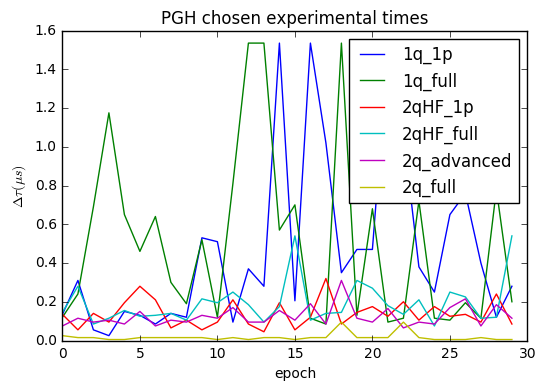

In [105]:
## Plots for experimental times chosen


for i in range(len(testTrackTime)):
    plt.plot(testTrackTime[i])

plt.title('PGH chosen experimental times')
plt.ylabel(r'$\Delta \tau (\mu s)$')
plt.xlabel(r'epoch')
plt.legend((testModelNames))

plt.show()

In [ ]:
# launch if a new run
testVolumeList = [modeltest.ModelsList[i].VolumeList  for i in range(len(testModelNames))]

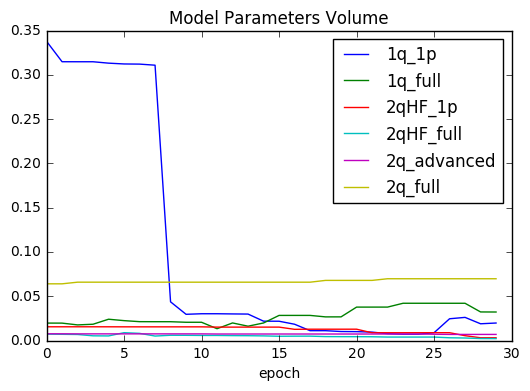

In [106]:
## Plots for Parameter Volume shrinking

for i in range(0, len(testVolumeList)):
    plt.plot(testVolumeList[i])

plt.title('Model Parameters Volume')
plt.xlabel(r'epoch')
plt.legend((testModelNames[0:]))

plt.show()

In [ ]:
# launch if a new run
testFinEstimParams = FinEstimParams

In [168]:
testFinEstimParams['2q_full'][range(3),0]

array([-2.89211754, -2.70041014, -2.01418793])

In [238]:
directory = os.path.join("..","..","..","Hamiltonian Learning With Seb","Decoherence_learning","NV05_HahnEcho02")
moredata =  mIO.ImportAllFolder_Hahnpeak(directory, clean_duplicates = True)  

myrange = range(0, min(moredata.shape[0],500)) 

# the 1000 factor converts ns to us
moredata = [ [moredata[i,0]/1000 , moredata[i,1]] for i in myrange]
moredata = np.array(moredata)

offset = 0.18
moredata[:,0] = moredata[:,0]-offset

Picture saved in
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\CompareData_LearntModel_noDeco_2017-08-18_16.52.20.pdf


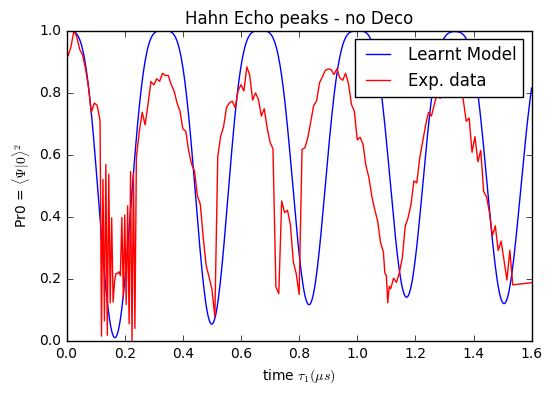

In [254]:
tvec = np.linspace(0.,1.6,500)

myHfA = testFinEstimParams['2q_full'][range(3),0]
myBathfreq = testFinEstimParams['2q_full'][range(3),1]

simdata = HTM.Q2_HF_Precession(tvec, HfA = myHfA, Bathfreq = myBathfreq)
plt.plot(tvec, simdata, "b-")

expdata = mIO.rescaledatatofullrange(moredata[:,1])
plt.plot(moredata[:,0], expdata, "r-")
plt.xlim([0,1.6])

plt.legend(('Learnt Model', 'Exp. data'))

plt.title(r'Hahn Echo peaks - no Deco')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $')

filefigname = dire+"\CompareData_LearntModel_noDeco"+mIO.mytimestamp()+".pdf"
filefigname = os.path.normpath(filefigname)
plt.savefig(filefigname)
print('Picture saved in\n'+filefigname)

plt.show()

Picture saved in
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\CompareData_LearntModel_2017-08-18_16.52.29.pdf


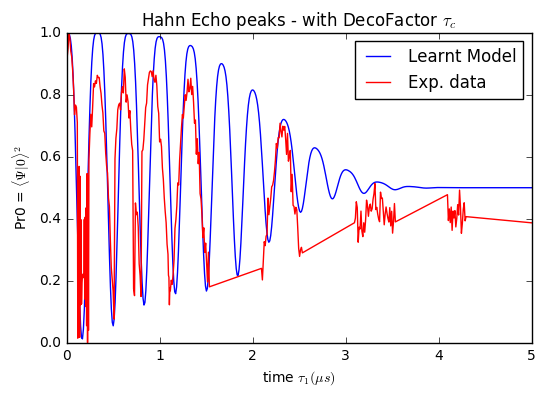

In [255]:
tvec = np.linspace(0.,5,500)

myHfA = testFinEstimParams['2q_full'][range(3),0]
myBathfreq = testFinEstimParams['2q_full'][range(3),1]

fit_tauc = 5 # the factor 0.5 below is because a scaling factor of 2x was introduced in the simulation
simdata = HTM.Q2_HF_Precession_deco(tvec, HfA = myHfA, Bathfreq = myBathfreq, decoTau_c = 0.5*fit_tauc)
plt.plot(tvec, simdata, "b-")

expdata = mIO.rescaledatatofullrange(moredata[:,1])
plt.plot(moredata[:,0], expdata, "r-")
plt.xlim([0,5])

plt.legend(('Learnt Model', 'Exp. data'))

plt.title(r'Hahn Echo peaks - with DecoFactor $\tau_c$')
plt.xlabel(r'time $\tau_1 (\mu s)$')
plt.ylabel(r'Pr0 = $\langle \Psi | 0 \rangle ^2 $')

filefigname = dire+"\CompareData_LearntModel"+mIO.mytimestamp()+".pdf"
filefigname = os.path.normpath(filefigname)
plt.savefig(filefigname)
print('Picture saved in\n'+filefigname)

plt.show()

$\hat H = a \hat\sigma_x + b \hat\sigma_y + c  \hat\sigma_z$

## Data export

In [280]:
import pickle
PIK = dire+"\HahnEchoPeak_QMD_QLE_offlineTEST(noMOVES)"+mIO.mytimestamp()+".dat"
print('Data saving in\n'+PIK)

Data saving in
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\test_results\HahnEchoPeak_QMD_QLE_offlineTEST(noMOVES)_2017-08-18_18.29.48.dat


In [282]:
data = [modeltest.ModelNames, AllBayesFactors, LogLikvals, FinEstimParams, 
        [modeltest.ModelsList[i].TrackTime  for i in range(len(modeltest.ModelsList))], 
        [modeltest.ModelsList[i].VolumeList  for i in range(len(modeltest.ModelsList))],
        [modeltest.ModelsList[i].LogLikelihoodList  for i in range(len(modeltest.ModelsList))],
        [modeltest.ModelsList[i].Particles  for i in range(len(modeltest.ModelsList))],
        [modeltest.ModelsList[i].Weights  for i in range(len(modeltest.ModelsList))]]

with open(PIK, "wb") as f:
    pickle.dump(data, f)

# <font color='red'>HIC SUNT LEONES</font> 

below was never used, potentially useful, pay much attention if running

# MULTIPLE testing running

In [89]:
nruns = 10
pool_len = 20
max_expnum = 30

collectTrueOpList = []
collectTrueNames = []
collectTrueParams = []

collectEstimParams = []

collectKfactorsDict = []
collectLogL = []


for run in range(nruns):
    modeltest = qmd.ModelsDevelopmentClass(HahnTestingList, allnameslist, checkloss=True, gaussian = False, trotter=False, IQLE=False, experimental='offline')
    collectTrueNames.append(modeltest.TrueNames)
    
    modeltest.InitialiseAllActiveModels()
    
    collectTrueParams.append(modeltest.TrueParamsList)
    
    start=time.clock()
    modeltest.UpdateAllActiveModels(expnum=max_expnum)
    end=time.clock()
    print('Total elapsed time for the learning process: ' + str(end-start))
    
    collectEstimParams.append([modeltest.ModelsList[i].NewEval for i in range(len(modeltest.ModelsList)) ])
    
    collectKfactorsDict.append(modeltest.ComputeAllBayesFactors(fromLogL = True))
    
    collectLogL.append([modeltest.ModelsList[i].KLogTotLikelihood for i in range(len(modeltest.ModelsList)) ])
    

Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Initial time selected > 2.41341870378
Final time selected > 0.935086134316
Final Parameters mean and stdev:[ 0.05048016  0.20570339]
Batch single time 0 elapsed time: 34.66650478012525


Initial time selected > 10.0650582324


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0017566974088713226. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0012517602879048657. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0008029118938015197. Clipping weights.
  warnings.warn("Negative weights occured 

Final time selected > 3.72591134139
Final Parameters mean and stdev:[ 0.19090293  0.20603459]
Batch single time 1 elapsed time: 30.796699964310392


Initial time selected > 1.3852050493
Final time selected > 0.921537928137
Final Parameters mean and stdev:[ 0.38249923  0.16703861]
Final Parameters mean and stdev:[ 0.36289034  0.21180432]
Final Parameters mean and stdev:[ 0.36024619  0.10362666]
Batch single time 2 elapsed time: 31.008563765088184


Initial time selected > 1.11443949146
Final time selected > 0.740096142291
Final Parameters mean and stdev:[-0.51781324  0.10791671]
Final Parameters mean and stdev:[-1.28857901  0.19299798]
Final Parameters mean and stdev:[-0.30196688  0.11348328]
Batch single time 3 elapsed time: 31.89598673655928


Initial time selected > 1.09486946133
Final time selected > 1.18884967519
Final Parameters mean and stdev:[-2.21962925  0.1912256 ]
Final Parameters mean and stdev:[-3.70678054  0.22011428]
Final Parameters mean and stdev:[ 17.47385854   0.12940

C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0020110608345902466. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0012010409021151634. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.003595602158295212. Clipping weights.
  warnings.warn("Negative weights occured i

LogTotLikelihoods updated
LogTotLikelihoods updated
LogTotLikelihoods updated
LogTotLikelihoods updated


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (1.8982919560755904). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


LogTotLikelihoods updated
New Bayes Factor update! Total elapsed time : 642.902543638189
Total elapsed time for the learning process: 836.1937692550637
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Initial time selected > 0.512288206986
Final time selected > 5.64653352863
Final Parameters mean and stdev:[ 1.30677073  0.09778671]
Batch single time 0 elapsed time: 37.7923541878954


Initial time selected > 1.62185837362


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0009250693802035154. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.00190885230255309. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0015065913370998125. Clipping weights.
  warnings.warn("Negative weights occured in

Final time selected > 3.76129519366
Final Parameters mean and stdev:[ 0.09764909  0.22248065]
Batch single time 1 elapsed time: 30.334869103640813


Initial time selected > 2.1934895542
Final time selected > 4.37411501689
Final Parameters mean and stdev:[ 0.76632739  0.19042724]
Final Parameters mean and stdev:[ 0.28275456  0.20414136]
Final Parameters mean and stdev:[ 0.49310226  0.12009348]
Batch single time 2 elapsed time: 31.08851320616668


Initial time selected > 1.86557893742
Final time selected > 0.962891042974
Final Parameters mean and stdev:[-2.58782184  0.16285544]
Final Parameters mean and stdev:[-2.59187995  0.40614142]
Final Parameters mean and stdev:[-0.4587507   0.06823079]
Batch single time 3 elapsed time: 32.83835413360066


Initial time selected > 2.22397214344
Final time selected > 2.04495313531
Final Parameters mean and stdev:[-2.67055782  0.17542796]
Final Parameters mean and stdev:[-3.99715955  0.17421419]
Final Parameters mean and stdev:[ 4.02011338  0.16469554]

C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (1.00000084421266). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


LogTotLikelihoods updated


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0034328318180599135. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.003044762770163226. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.001967181354498748. Clipping weights.
  warnings.warn("Negative weights occured in

LogTotLikelihoods updated
LogTotLikelihoods updated


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (3.7604647957221693). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


LogTotLikelihoods updated


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (2.9135135552162583). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


LogTotLikelihoods updated


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (3.604655762903452). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


LogTotLikelihoods updated
New Bayes Factor update! Total elapsed time : 653.067177950059
Total elapsed time for the learning process: 849.5950221046332
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Initial time selected > 0.279742522898
Final time selected > 1.03795968794
Final Parameters mean and stdev:[ 0.00924443  0.32442466]
Batch single time 0 elapsed time: 34.45650383330212


Initial time selected > 2.09269504773


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0016799664006719838. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0018005851901868103. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0009207749856128911. Clipping weights.
  warnings.warn("Negative weights occured 

Final time selected > 3.56437309346
Final Parameters mean and stdev:[ 0.40959475  0.19658513]
Batch single time 1 elapsed time: 30.79647617023511


Initial time selected > 1.23897432236
Final time selected > 1.04616810122
Final Parameters mean and stdev:[ 0.66526552  0.18851002]
Final Parameters mean and stdev:[ 0.79060697  0.15162356]
Final Parameters mean and stdev:[ 0.70963358  0.12664771]
Batch single time 2 elapsed time: 31.02008187685351


Initial time selected > 0.86864181026


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.192072187180722). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 8.58711927908
Final Parameters mean and stdev:[-1.81777268  0.0327559 ]
Final Parameters mean and stdev:[-3.13111602  0.05577567]
Final Parameters mean and stdev:[-3.35520099  0.11299985]
Batch single time 3 elapsed time: 33.33376536184005


Initial time selected > 0.963306155358
Final time selected > 0.830285084068
Final Parameters mean and stdev:[-1.75371822  0.21193589]
Final Parameters mean and stdev:[-1.96744588  0.25020225]
Final Parameters mean and stdev:[ 11.14658638   0.24062527]
Batch single time 4 elapsed time: 33.35156758482117


Initial time selected > 0.131419499139
Final time selected > 0.0937407564957
Final Parameters mean and stdev:[-2.83001195  0.20617545]
Final Parameters mean and stdev:[-2.68617475  0.20645901]
Final Parameters mean and stdev:[-1.99707809  0.1926878 ]
Final Parameters mean and stdev:[ 3.97135324  1.90666702]
Final Parameters mean and stdev:[-0.38649963  1.86836976]
Final Parameters mean and stdev:[-0.39501084  1.87489527]
Batch

C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0014938910526596512. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.00010847972446149888. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0002543676755210555. Clipping weights.
  warnings.warn("Negative weights occured

LogTotLikelihoods updated
LogTotLikelihoods updated
LogTotLikelihoods updated


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.197086982955351). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


LogTotLikelihoods updated


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (4.9742390447074465). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


LogTotLikelihoods updated
New Bayes Factor update! Total elapsed time : 654.0373001164662
Total elapsed time for the learning process: 848.0803195620538
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Remember to adopt the corrct 'pr0fromHahn' definition!!!
Initialization Ready
Initial time selected > 1.95823965042
Final time selected > 0.994554330146
Final Parameters mean and stdev:[ 1.12341189  0.28763173]
Batch single time 0 elapsed time: 37.76560847822111


Initial time selected > 3.01772166218


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.0008547008547008544. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.01008064516129032. Clipping weights.
  warnings.warn("Negative weights occured in particle approximation. Smallest weight observed == {}. Clipping weights.".format(np.min(weights)), ApproximationWarning)
C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:429: ApproximationWarning: Negative weights occured in particle approximation. Smallest weight observed == -0.001866716445771887. Clipping weights.
  warnings.warn("Negative weights occured in 

RuntimeError: All particle weights are zero.

## Data export

In [45]:
import pickle
PIK = "testQMD_QLE_epochs"+str(max_expnum)+"pool"+str(pool_len)+".dat"

In [46]:
data = [collectTrueOpList, collectTrueNames, collectTrueParams, collectEstimParams, collectKfactorsDict, collectLogL]
with open(PIK, "wb") as f:
    pickle.dump(data, f)

## Data import

In [728]:
import pickle

with open(PIK, "rb") as f:
    dataold = pickle.load(f)

## Overall results 
#### applying directly the champion rule as the highest BayesFactor

In [ ]:
myModelNames = modeltest.ModelNames

In [ ]:
performance = []
for ids in range(3):
    performance.append(collectTrueNames[ids]==myModelNames[np.argmax(np.array(collectLogL[ids]))])
print("Correctly estimated model in " + str(100*sum(performance)/len(performance)) + "% of cases")